<h1>CADRL Complete Training (IL + RL)</h1>

Import the necessary packages

In [11]:
from jax import random, vmap, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt
import os

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.cadrl import CADRL
from socialjym.policies.sarl import SARL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials, save_policy_params
from socialjym.utils.rewards.reward1 import generate_reward_done_function

Set the training hyperparameters

In [12]:
training_hyperparams = {
    'random_seed': 0,
    'policy_name': 'cadrl', # 'cadrl' or 'sarl'
    'n_humans': 1,  # CADRL uses 1, SARL uses 5
    'il_training_episodes': 3_000,
    'il_learning_rate': 0.01, # CADRL uses 0.01, SARL uses 0.001
    'il_num_epochs': 50, # Number of epochs to train the model after ending IL
    'rl_training_episodes': 10_000,
    'rl_learning_rate': 0.001,
    'rl_num_batches': 100, # Number of batches to train the model after each RL episode
    'batch_size': 100, # Number of experiences to sample from the replay buffer for each model update
    'epsilon_start': 0.5,
    'epsilon_end': 0.1,
    'epsilon_decay': 4_000,
    'buffer_size': 100_000, # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
    'target_update_interval': 50, # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)
    'humans_policy': 'hsfm',
    'scenario': 'hybrid_scenario',
}

Set the reward and environment parameters

In [13]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': -0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': training_hyperparams['n_humans'],
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': training_hyperparams['scenario'],
    'humans_policy': training_hyperparams['humans_policy'],
    'circle_radius': 7,
    'reward_function': reward_function,
}

Initialize environment, robot policy and replay buffer

In [14]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
if training_hyperparams['policy_name'] == "cadrl": policy = CADRL(env.reward_function, dt=env_params['robot_dt'])
elif training_hyperparams['policy_name'] == "sarl": policy = SARL(env.reward_function, dt=env_params['robot_dt'])
else: raise ValueError(f"{training_hyperparams['policy_name']} is not a valid policy name")
initial_vnet_params = policy.model.init(random.key(training_hyperparams['random_seed']), jnp.zeros((policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(training_hyperparams['buffer_size'], training_hyperparams['batch_size'])

<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [15]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=training_hyperparams['il_learning_rate'], momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((training_hyperparams['buffer_size'], env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((training_hyperparams['buffer_size'],1)),
}

Set all the parameters for the imitation learning rollout

In [16]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': training_hyperparams['il_training_episodes'],
    'random_seed': training_hyperparams['random_seed'],
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': training_hyperparams['buffer_size'],
    'num_epochs': training_hyperparams['il_num_epochs'],
    'batch_size': training_hyperparams['batch_size'],
    'time_limit': reward_params['time_limit'],
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [17]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|██████████| 3000/3000 [00:04<00:00, 736.22it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

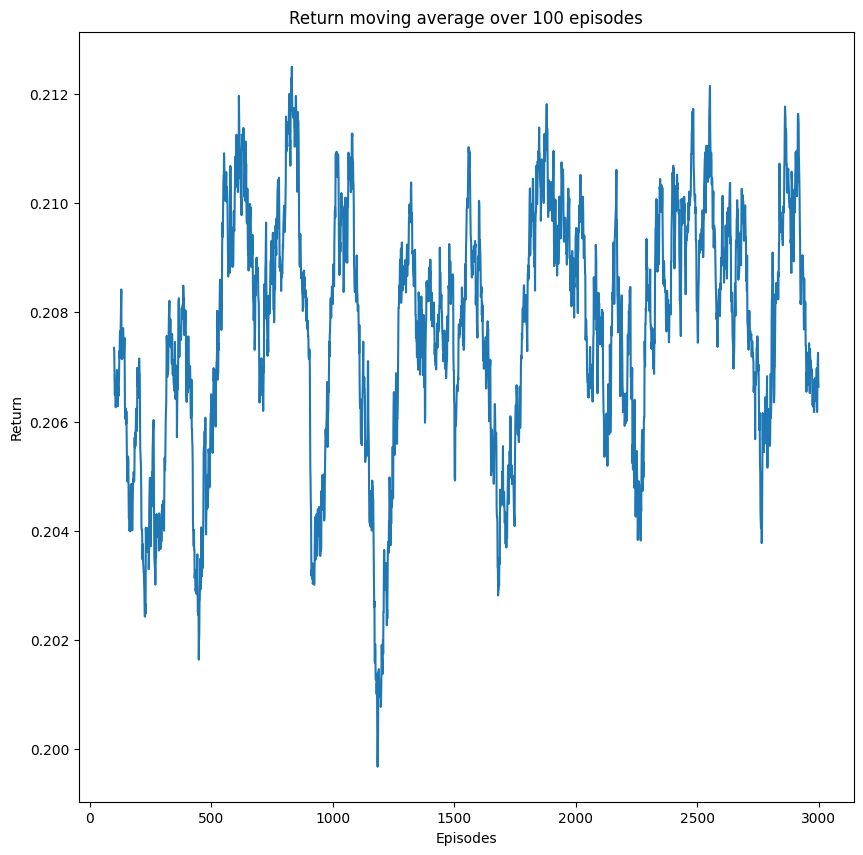

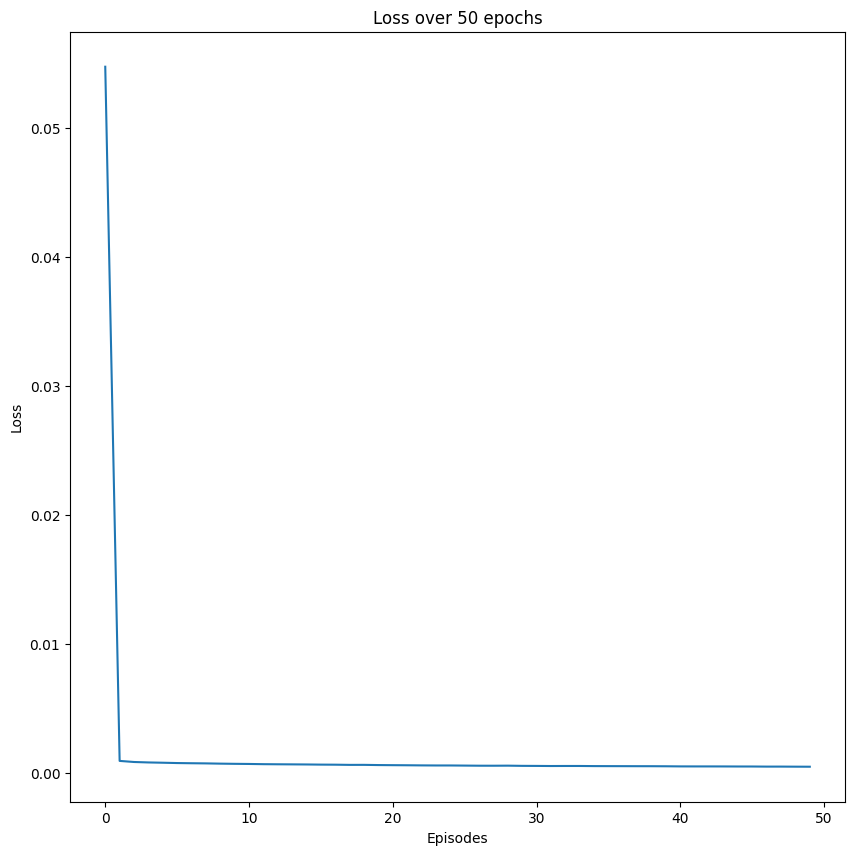

In [18]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials. The robot is still NOT visible by humans here.

In [19]:
test_k_trials(
    1000, 
    training_hyperparams['random_seed'] + training_hyperparams['il_training_episodes'], 
    env, 
    policy, 
    il_model_params, 
    reward_params["time_limit"])


Executing 1000 tests with 1 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:09<00:00, 110.59it/s]

RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.13
SPL: 0.72
Average time to goal: 20.52 s
Average path length: 20.51 m
Average speed: 1.00 m/s
Average acceleration: 0.39 m/s^2
Average jerk: 2.96 m/s^3
Average space compliance: 0.99
Average minimum distance to humans: 2.61 m


{'average_acceleration': Array([0.46792918, 0.39234504, 0.4227678 , 0.29169837, 0.42153952,
        0.45191056, 0.43432018, 0.21853948, 0.26172155, 0.37472662,
        0.29599908, 0.50345886, 0.28121123, 0.46721706, 0.5457084 ,
        0.485387  , 0.836902  , 0.5202407 , 0.26012042, 0.3060441 ,
        0.22242485, 0.4752213 , 0.6214362 , 0.28721067, 0.41619265,
        0.48030955, 0.4616721 , 0.3567186 , 0.29169828, 0.28984848,
        0.33460632, 0.32110184, 0.43866584, 0.39360112, 0.632224  ,
        0.43127728, 0.36249375, 0.42644745, 0.41799894, 0.40179965,
        0.19924115, 0.44120505, 0.40132856, 0.4296782 , 0.3737737 ,
        0.4553601 , 0.37160066, 0.27690238, 0.37270984, 0.44553527,
        0.5247622 , 0.22296032, 0.23917249, 0.3639993 , 0.5336724 ,
        0.31151313, 0.29585698, 0.3682604 , 0.40648124, 0.38417783,
        0.37319383, 0.13887101, 0.4594441 , 0.36883152, 0.35490197,
        0.44969967, 0.42769918, 0.49451545, 0.36546475, 0.2675524 ,
        0.32844993, 0.37

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [22]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=training_hyperparams['rl_learning_rate'], momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': training_hyperparams['rl_training_episodes'],
    'random_seed': training_hyperparams['random_seed'] + training_hyperparams['il_training_episodes'],
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': training_hyperparams['buffer_size'],
    'num_batches': training_hyperparams['rl_num_batches'],
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': training_hyperparams['epsilon_start'],
    'epsilon_end': training_hyperparams['epsilon_end'],
    'decay_rate': training_hyperparams['epsilon_decay'],
    'target_update_interval': training_hyperparams['target_update_interval'],
    'time_limit': reward_params['time_limit'],
}

Let's start the RL rollout.

In [23]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 10,000 iterations: 100%|██████████| 10000/10000 [14:16<00:00, 11.67it/s]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

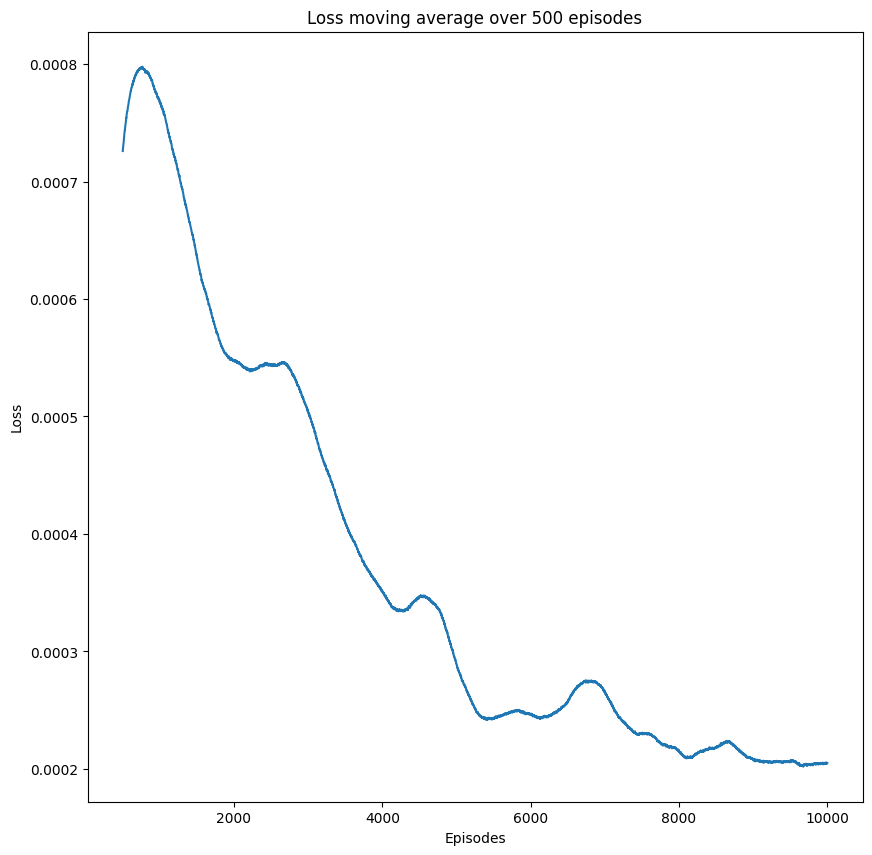

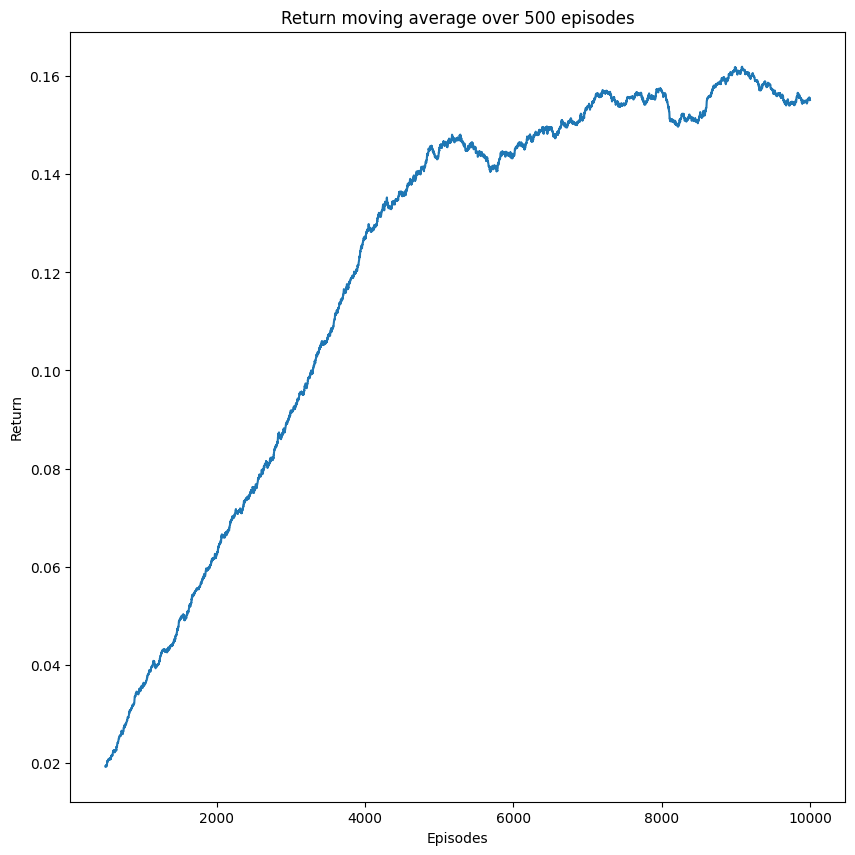

In [24]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environments the robot is visible.

In [25]:
env5_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': training_hyperparams['scenario'],
    'humans_policy': training_hyperparams['humans_policy'],
    'reward_function': reward_function,
}
env5 = SocialNav(**env5_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': training_hyperparams['scenario'],
    'humans_policy': training_hyperparams['humans_policy'],
    'reward_function': reward_function,
}
env10 = SocialNav(**env10_params)
env15_params = {
    'robot_radius': 0.3,
    'n_humans': 15,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': training_hyperparams['scenario'],
    'humans_policy': training_hyperparams['humans_policy'],
    'reward_function': reward_function,
}
env15 = SocialNav(**env15_params)
## Execute tests
test_k_trials(
    1000, 
    training_hyperparams['random_seed'] + training_hyperparams['il_training_episodes'] + training_hyperparams['rl_training_episodes'], 
    env5, 
    policy, 
    final_model_params, 
    reward_params["time_limit"])
test_k_trials(
    1000, 
    0, # The seed does not matter since the environment has more humans than the training one
    env10, 
    policy, 
    final_model_params, 
    reward_params["time_limit"])
test_k_trials(
    1000, 
    0, # The seed does not matter since the environment has more humans than the training one
    env15, 
    policy, 
    final_model_params, 
    reward_params["time_limit"]) 


Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:41<00:00, 24.00it/s]


RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.19
SPL: 0.90
Average time to goal: 15.92 s
Average path length: 15.55 m
Average speed: 0.98 m/s
Average acceleration: 0.83 m/s^2
Average jerk: 5.87 m/s^3
Average space compliance: 0.90
Average minimum distance to humans: 0.51 m

Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:41<00:00,  9.86it/s]


RESULTS
Success rate: 0.99
Collision rate: 0.00
Timeout rate: 0.01
Average return: 0.17
SPL: 0.87
Average time to goal: 16.54 s
Average path length: 16.02 m
Average speed: 0.97 m/s
Average acceleration: 0.96 m/s^2
Average jerk: 6.69 m/s^3
Average space compliance: 0.80
Average minimum distance to humans: 0.27 m

Executing 1000 tests with 15 humans...


Running for 1,000 iterations: 100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]

RESULTS
Success rate: 0.99
Collision rate: 0.00
Timeout rate: 0.01
Average return: 0.15
SPL: 0.85
Average time to goal: 17.24 s
Average path length: 16.58 m
Average speed: 0.96 m/s
Average acceleration: 1.09 m/s^2
Average jerk: 7.42 m/s^3
Average space compliance: 0.71
Average minimum distance to humans: 0.22 m


{'average_acceleration': Array([0.78398824, 1.2491889 , 0.7013355 , 1.2662641 , 1.5526164 ,
        1.3841547 , 1.2729235 , 0.68014777, 0.9969905 , 0.8549792 ,
        1.4280695 , 0.60051847, 1.1746311 , 1.3232245 , 0.84460497,
        1.751192  , 1.1179667 , 1.5009631 , 0.5202408 , 0.94036144,
        0.6912986 , 0.87386537, 1.2204151 , 1.1177492 , 1.3582531 ,
        1.5679522 , 1.5617974 , 0.9433871 , 0.6205226 , 1.1862377 ,
        1.381591  , 0.7872865 , 0.86586964, 0.9596384 , 1.3118347 ,
        1.1369193 , 1.7606666 , 0.82938635, 1.4050019 , 1.0826286 ,
        1.28348   , 0.71929276, 0.6240184 , 1.2462159 , 1.3222319 ,
        0.7173093 , 1.244855  , 0.7359638 , 1.0220319 , 0.8577913 ,
        0.72651565, 1.2073013 , 1.2750715 , 1.4869629 , 1.4153359 ,
        1.383496  , 1.2912617 , 1.5596892 , 1.4971068 , 1.3353915 ,
        0.9987435 , 1.2772871 , 1.2868531 , 1.2032102 , 1.2727327 ,
        0.3693244 , 1.5271748 , 1.1143278 , 1.1295758 , 1.0513657 ,
        0.60027957, 1.45

Save the trained policy parameters

In [26]:
save_policy_params(
    training_hyperparams['policy_name'], 
    final_model_params, 
    env_params, 
    reward_params, 
    training_hyperparams, 
    os.path.join(os.path.expanduser("~"),"Repos/social-jym/trained_policies/socialjym_policies/"))

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 3.96 seconds - Plotting trajectory...


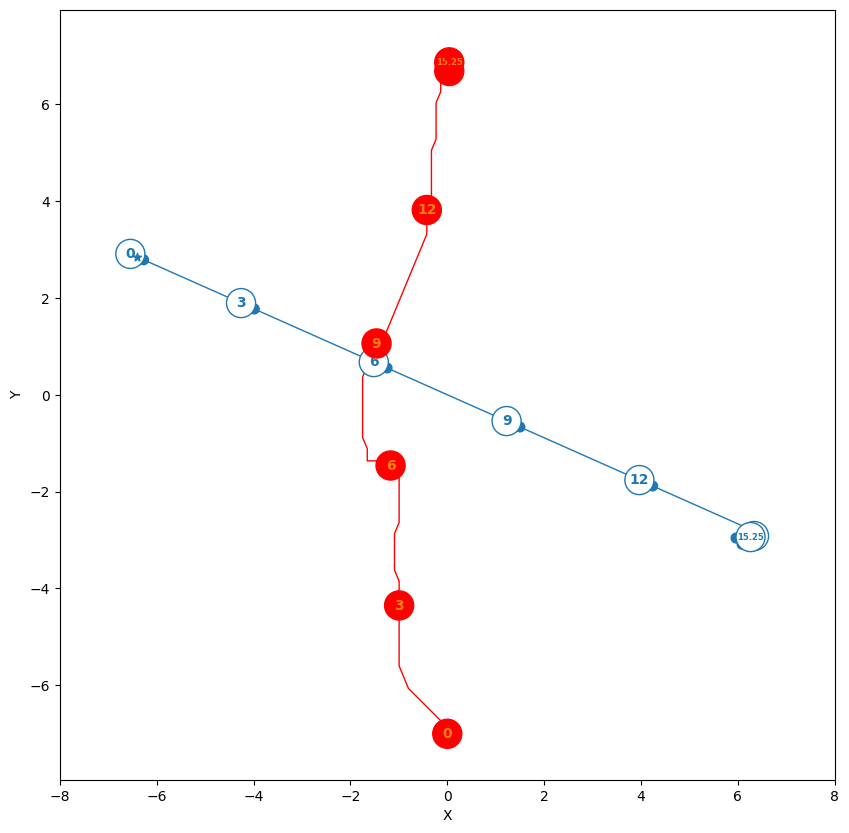

Episode 1 ended - Execution time 0.03 seconds - Plotting trajectory...


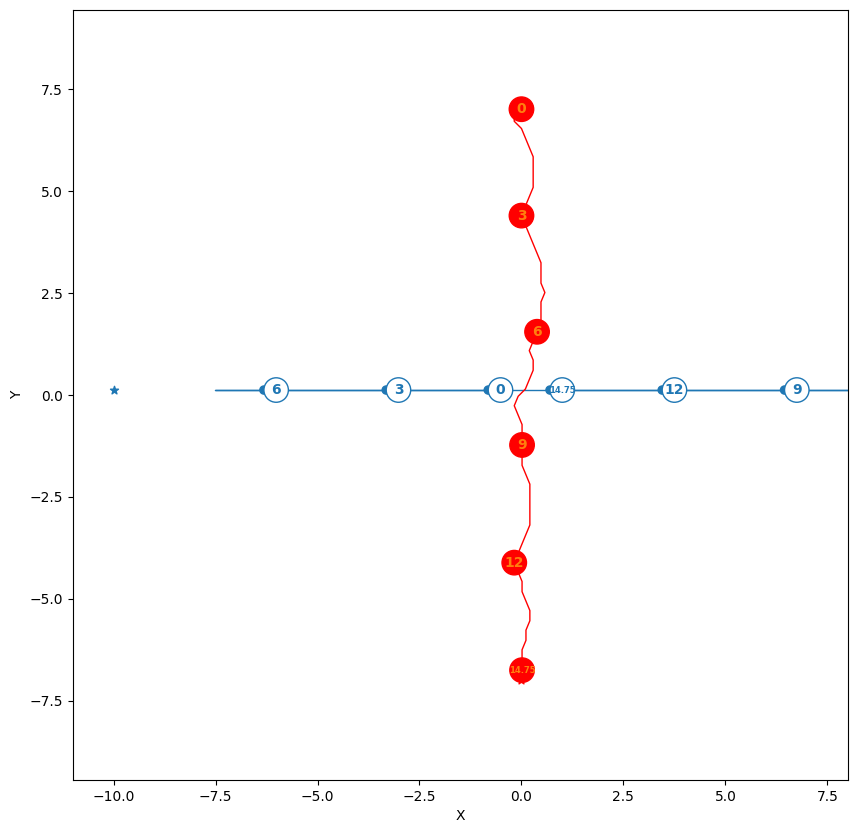

Episode 2 ended - Execution time 0.02 seconds - Plotting trajectory...


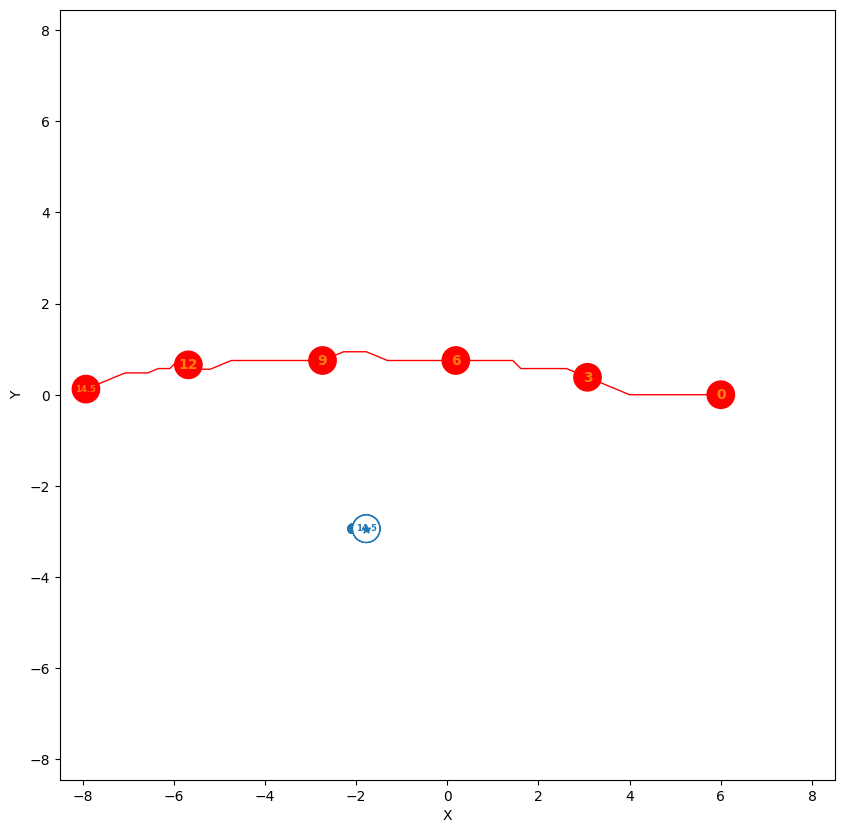

Episode 3 ended - Execution time 0.02 seconds - Plotting trajectory...


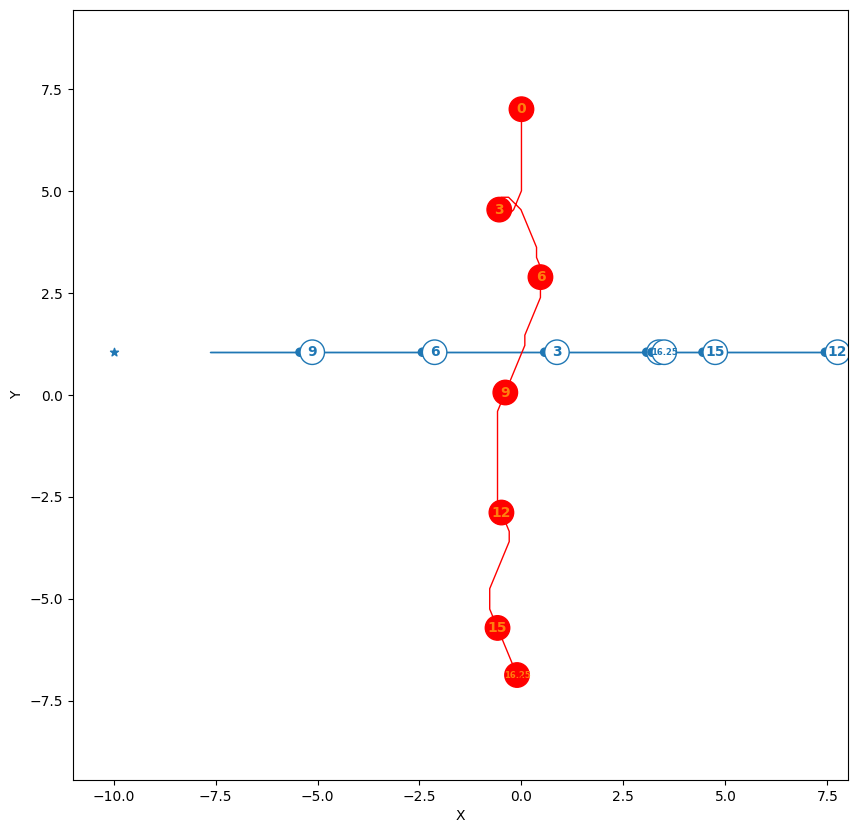

Episode 4 ended - Execution time 0.02 seconds - Plotting trajectory...


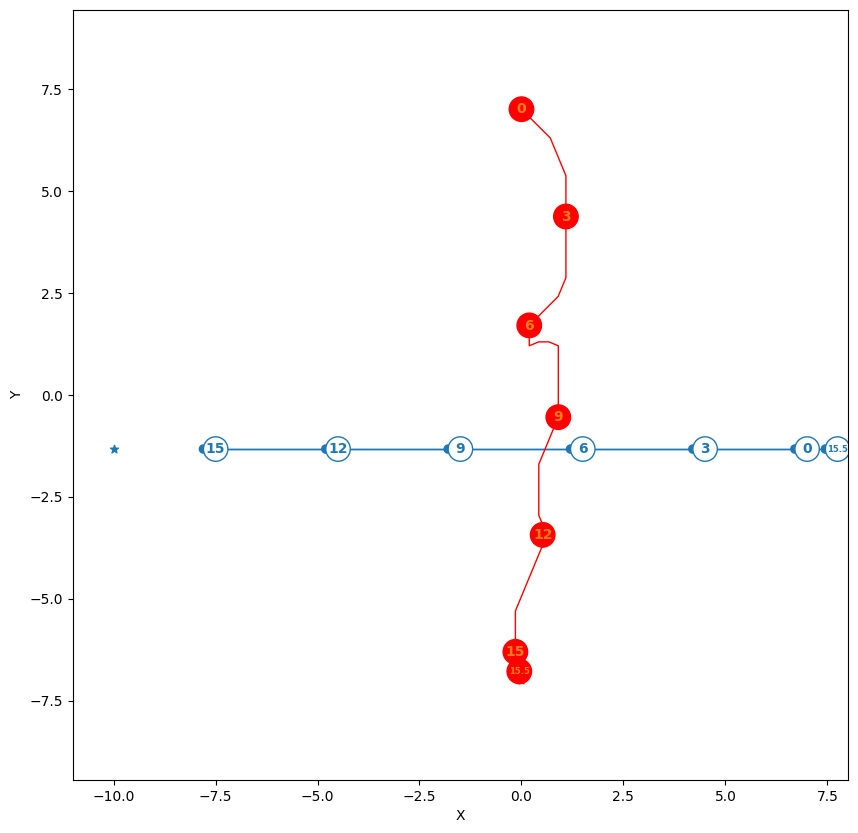

Average time per episode: 0.81 seconds
Total time for 5 episodes: 4.05 seconds


In [27]:
n_episodes = 5
env_params["n_humans"] = 1
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    policy_key, reset_key = vmap(random.PRNGKey)(jnp.zeros(2, dtype=int) + i)
    outcome = {"nothing": True, "success": False, "failure": False, "timeout": False}
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while outcome["nothing"]:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, outcome = env.step(state,info,action,test=True) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")